# Getting Started

In this notebook, we will walk you through a minimal example for candidate generation and re-reranking with the [Quaero](https://quaerofrenchmed.limsi.fr/) corpus.

## Preparation

Go to the root folder of the repository and run the following commands

`xmen dict examples/conf/quaero.yaml`

This command creates the Quaero-specific UMLS subset as a jsonl file.
If you don't have access to UMLS metathesaurus 2014AB release, you can adapt the yaml file to point to any other release.

`xmen index examples/conf/quaero.yaml --all`

This command creates the indices used candidate generations (both TF-IDF and SapBERT).

By default, all files are written to `~/.cache/xmen`, unless configured otherwise.

## Loading Knowledge Base and Dataset

In [2]:
from pathlib import Path
base_path = Path.home() / ".cache/xmen/quaero"

In [3]:
# Load Quaero MEDLINE subset through BigBIO dataloader
from datasets import load_dataset
dataset = load_dataset("bigbio/quaero", "quaero_medline_bigbio_kb")

Found cached dataset quaero (/home/Florian.Borchert/.cache/huggingface/datasets/bigbio___quaero/quaero_medline_bigbio_kb/1.0.0/c215a01af5fd15163e392e2f78a4f67f1fe3567d92f53b7f907c95e55dcdfe93)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Load knowledge base
from xmen import load_kb
kb = load_kb(base_path / "quaero.jsonl")

# Candidate Generation

We use the pre-computed indices to retrieve the 64 most similar concepts for each mention

In [5]:
# Generate candidates with Ensemble of TF-IDF + SapBERT
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / "index")

[10/18/23 12:38:31] INFO     Loading hierarchical faiss index                                ]8;id=392403;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=659557;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=729210;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=552471;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/quaero/index/sapbert/embed_fais                    
                             s_hier.pickle                                                                         

[10/18/23 12:39:06] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=461408;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=307951;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 6910830                                                                          

In [6]:
candidates = linker.predict_batch(dataset, top_k=64)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [7]:
from xmen.evaluation import evaluate
evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.5802389409105586,
  'recall': 0.5804263565891473,
  'fscore': 0.5803326336186015,
  'ptp': 1797,
  'fp': 1300,
  'rtp': 1797,
  'fn': 1299,
  'n_docs_system': 833,
  'n_annos_system': 3103,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Semantic Group Filtering

In [8]:
from xmen.data import SemanticGroupFilter
candidates = SemanticGroupFilter(kb).transform_batch(candidates)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [9]:
evaluate(dataset['test'], candidates['test'])

{'strict': {'precision': 0.6606276285991588,
  'recall': 0.6595607235142119,
  'fscore': 0.6600937449490868,
  'ptp': 2042,
  'fp': 1049,
  'rtp': 2042,
  'fn': 1054,
  'n_docs_system': 833,
  'n_annos_system': 3095,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Reranking

## Using a Pre-trained Model for Reranking

When no are little annotated training data is available, a pre-trained model can provide good re-ranking performance.
Here, we use a cross-encoder that was trained on an automatically translated version of MedMentions (see the notebook [01_Translation.ipynb](01_Translation.ipynb))

In [10]:
from xmen.reranking.cross_encoder import *
ce_dataset = CrossEncoderReranker.prepare_data(candidates, dataset, kb)

Context length: 128
Use NIL values: True


  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

In [11]:
# CE re-ranker, pre-trained on French translation of MedMentions
rr = CrossEncoderReranker.load("phlobo/xmen-fr-ce-medmentions", device=0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
# Predict on test set
prediction = rr.rerank_batch(candidates["test"], ce_dataset["test"], allow_nil=False)

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

In [13]:
evaluate(dataset['test'], prediction)

{'strict': {'precision': 0.7234248788368336,
  'recall': 0.7231912144702842,
  'fscore': 0.7233080277822647,
  'ptp': 2239,
  'fp': 856,
  'rtp': 2239,
  'fn': 857,
  'n_docs_system': 833,
  'n_annos_system': 3095,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

## Training a Fully-supervised Model

Finally, with enough training data, we can also train a fully supervsied cross-encoder to learn a better task-specific ranking.

The cross-encoder is trained with batches of 64 candidates. 
We keep the checkpoint that maximizes accuracy@1 on the validation set.

In [17]:
# Train the cross-encoder on the training set and use the validation set for model selection
rr_fs = CrossEncoderReranker()
# Note: we train for 3 epochs only (you likely want to increase this for better performance)
args = CrossEncoderTrainingArgs(num_train_epochs=3)
rr_fs.fit(args, ce_dataset["train"].dataset, ce_dataset["validation"].dataset, show_progress_bar=False)

model_name := bert-base-multilingual-cased
num_train_epochs := 3
fp16 := True
label_smoothing := False
rank_regularization := 1.0
train_layers := None
softmax_loss := True
random_seed := 42
learning_rate := 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2023-10-18 13:49:28 - Use pytorch device: cuda
2023-10-18 14:08:02 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-10-18 14:18:57 - Accuracy: 0.7233468286099866
2023-10-18 14:18:57 - Accuracy @ 5: 0.861336032388664
2023-10-18 14:18:57 - Accuracy @ 64: 0.9946018893387314
2023-10-18 14:18:57 - Baseline Accuracy: 0.6686909581646424
2023-10-18 14:18:57 - Save model to ./output/cross_encoder
2023-10-18 14:37:28 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-10-18 14:48:25 - Accuracy: 0.7435897435897436
2023-10-18 14:48:25 - Accuracy @ 5: 0.8711201079622132
2023-10-18 14:48:25 - Accuracy @ 64: 0.9946018893387314
2023-10-18 14:48:25 - Baseline Accuracy: 0.6686909581646424
2023-10-18 14:48:25 - Save model to ./output/cross_encoder
2023-10-18 15:07:04 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-10-18 15:18:02 - Accuracy: 0.7510121457489879
2023-10-18 15:18:02 - Accuracy @ 5: 0.873481781

In [18]:
# Predict on test set
prediction_fs = rr_fs.rerank_batch(candidates["test"], ce_dataset["test"])

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

# Evaluation

## Metrics

We compute metrics for the predicted concepts vs. the gold-standard for different values of k

In [19]:
evaluate(dataset['test'], prediction_fs)

{'strict': {'precision': 0.7528015820698748,
  'recall': 0.7377260981912145,
  'fscore': 0.7451876019575857,
  'ptp': 2284,
  'fp': 750,
  'rtp': 2284,
  'fn': 812,
  'n_docs_system': 833,
  'n_annos_system': 3034,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

In [20]:
from xmen.evaluation import evaluate_at_k
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.6595607235142119
Recall@2 0.790374677002584
Recall@4 0.8449612403100775
Recall@8 0.8656330749354005
Recall@16 0.8853359173126615
Recall@32 0.8963178294573644
Recall@64 0.8998708010335917


In [21]:
_ = evaluate_at_k(dataset['test'], prediction_fs)

Recall@1 0.7377260981912145
Recall@2 0.8049095607235142
Recall@4 0.8397932816537468
Recall@8 0.8601421188630491
Recall@16 0.8782299741602068
Recall@32 0.8888888888888888
Recall@64 0.8934108527131783


## Error Analysis

To gain more insights into the ranking errors (and potential NER errors, which do not apply here), we use the `error_analysis` functionality of xmen

In [22]:
from xmen.evaluation import error_analysis

In [23]:
# Before re-ranking
ea_df = error_analysis(dataset['test'], candidates['test'], tasks=['nen'])
ea_df.head(10)

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,0,5,[Etude],"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1,NaN,C0013621,0.692185,1009657
1,1,False,47,55,[Africain],"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,0,0.863724,C0027567,0.863724,1009657
2,1,False,4,13,[gangrènes],"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0,0.973051,C0017086,0.973051,1009808
3,2,False,4,22,[gangrènes gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0,0.935468,C0017105,0.935468,1009808
4,1,False,14,22,[gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,2,0.808053,C0537495,0.858877,1009808
5,1,False,35,46,[tuberculose],"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0,1.0,C0041296,1.0,1019393
6,2,False,35,53,[tuberculose bovine],"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0,1.0,C0041307,1.0,1019393
7,1,False,47,53,[bovine],"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,3,1.0,C3667982,1.0,1019393
8,2,False,56,75,[Mycobacterium bovis],"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1,NaN,C0041307,0.825099,1019393
9,1,False,78,86,[observés],"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,1,0.852574,C0700325,0.852574,1019393


In [24]:
# After Re-Ranking
ea_df = error_analysis(dataset['test'], prediction_fs, tasks=['nen'])
ea_df.head(10)

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,0,5,[Etude],"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1,NaN,NIL,NaN,1009657
1,1,False,47,55,[Africain],"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,1,0.037805,C0085756,0.041022,1009657
2,1,False,4,13,[gangrènes],"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0,0.042884,C0017086,0.042884,1009808
3,2,False,4,22,[gangrènes gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0,0.061593,C0017105,0.061593,1009808
4,1,False,14,22,[gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,0,0.090157,C0017110,0.090157,1009808
5,1,False,35,46,[tuberculose],"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0,0.04742,C0041296,0.04742,1019393
6,2,False,35,53,[tuberculose bovine],"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0,0.062842,C0041307,0.062842,1019393
7,1,False,47,53,[bovine],"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,0,0.087439,C0007452,0.087439,1019393
8,2,False,56,75,[Mycobacterium bovis],"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1,NaN,C0041307,0.550823,1019393
9,1,False,78,86,[observés],"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,0,0.050934,C0302523,0.050934,1019393


<Axes: xlabel='pred_index'>

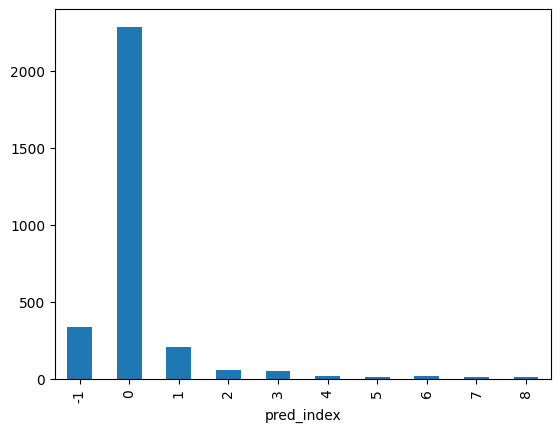

In [25]:
ea_df.pred_index.value_counts().sort_index().iloc[0:10].plot.bar()